- [previous file - EDA](2022-03-31_train-test_EDA.ipynb)
- [previous file - sklearn experiments](2022-04-12_experiments-sklearn.ipynb)
- [next file - ensembles](2022-04-15_ensemble.ipynb)

## imports

In [2]:
from warnings import filterwarnings
import os
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

sns.set()
filterwarnings("ignore")

## preprocessing

### reading data

In [3]:
path_to_data = "data"
# path_to_data = "https://github.com/XelorR/sf_project_6/raw/master/data"

train_raw = pd.read_parquet(f"{path_to_data}/2022-04-08_train_pre-model.parquet")
test_raw = pd.read_parquet(f"{path_to_data}/2022-04-08_test_pre-model.parquet")

train_raw.shape, test_raw.shape

((115367, 30), (34686, 28))

### functions

In [4]:
def train_or_load(clf, X, y, filepath: str = "model.joblib", complevel: int = 9):
    """
    Fits and serialize model as .pkl, .pickle or .joblib file.
    Loads serialized model if filepath exists.

    clf - model to fit
    X - dateset
    y - lables
    filepath - where to save
    complevel - compression level (0-9) for joblib, ignored for pickle
    """
    if filepath.endswith(".joblib"):
        if os.path.exists(filepath):
            with open(filepath, "rb") as f:
                clf = joblib.load(f)
        else:
            clf.fit(X, y)
            with open(filepath, "wb") as f:
                joblib.dump(clf, f, compress=complevel)
        return clf
    elif filepath.endswith(".pkl") or filepath.endswith(".pickle"):
        if os.path.exists(filepath):
            with open(filepath, "rb") as f:
                clf = pickle.load(f)
        else:
            clf.fit(X, y)
            with open(filepath, "wb") as f:
                pickle.dump(clf, f)
        return clf


def submit(hold_out: pd.DataFrame, model, name="submission"):
    preds = model.predict(hold_out)
    submission = pd.read_csv(f"{path_to_data}/sample_submission.csv")
    submission["price"] = preds
    submission.to_csv(f"{name}.csv", index=False)


def submit_log(hold_out: pd.DataFrame, model, name="submission"):
    preds = model.predict(hold_out)
    submission = pd.read_csv(f"{path_to_data}/sample_submission.csv")
    submission["price"] = np.exp(preds)
    submission.to_csv(f"{name}.csv", index=False)

### encoding

In [5]:
train_raw["train/test"] = "train"
test_raw["train/test"] = "test"

data = train_raw.append(test_raw)
data["ptc"].fillna("Оригинал", inplace=True)

data[data.select_dtypes("object").columns.tolist()] = data[
    data.select_dtypes("object").columns.tolist()
].astype(str)

for col in set(data.select_dtypes(exclude=("object")).columns) - {"price"}:
    data[col] = (
        RobustScaler().fit_transform(data[col].values.reshape(-1, 1)).reshape(-1, 1)
    )

for col in ["model_name"]:
    data[col] = LabelEncoder().fit_transform(data[col].astype("str"))

data = pd.get_dummies(
    data,
    columns=[
        "vehicle_transmission",
        "vendor",
        "brand",
        "fuel_type",
        "body_type",
        "color",
        "ptc",
        "drive",
        "wheel",
        "age_cat",
    ],
)

train = data.loc[data["train/test"] == "train"]

train_jane = train.loc[train["sample"] == "jane"]
train_sokolov = train.loc[train["sample"] == "sokolov"]
train_jane["price"] = train_jane["price"] * 0.86
train = train_jane.append(train_sokolov)

train.drop(columns=["sample", "description", "train/test"], inplace=True)
test = data.loc[data["train/test"] == "test"].drop(
    columns=["sample", "description", "train/test", "price"]
)

### preparing to train models

In [6]:
if os.path.exists("models"):
    pass
else:
    os.mkdir("models")

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop(columns="price"), train["price"], random_state=42, shuffle=True
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((86525, 112), (86525,), (28842, 112), (28842,))

## Experiment

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session

print("We're using TF", tf.__version__)
print("We are using Keras", tf.keras.__version__)

We're using TF 2.4.1
We are using Keras 2.4.0


In [37]:
clear_session()

model = Sequential()
model.add(Dense(1024, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(512, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="relu"))

model.compile(
    loss="mean_absolute_percentage_error", optimizer="adam", metrics=["mean_absolute_percentage_error", "accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              115712    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 673,409
Trainable params: 673,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train, y_train, epochs=200, batch_size=4096, validation_data=(X_valid, y_valid)
)

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


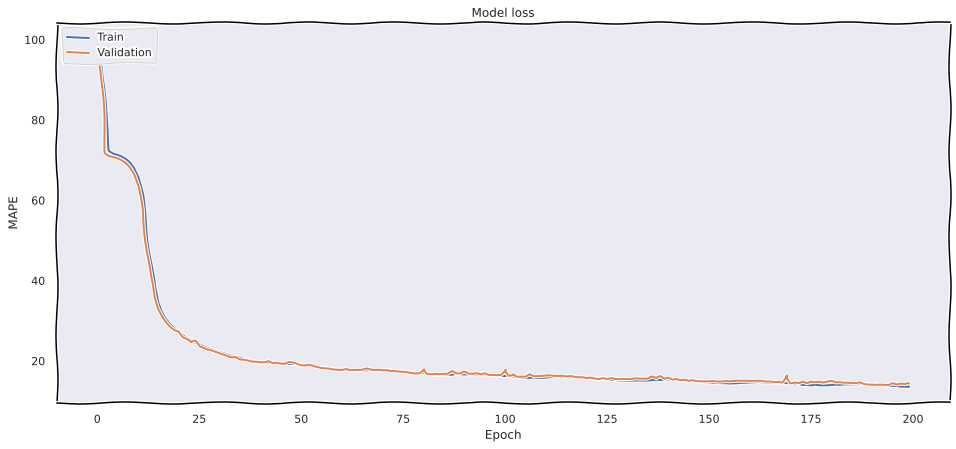

In [40]:
with plt.xkcd():
    plt.subplots(figsize=(16, 7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('MAPE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [42]:
submit(test, model, "keras_v1")

## Kaggle score: 15.49165